In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
n = 100 # samples per class
D = 2 # number of parameters
K = 3 # number of classes
N = n*K # total sample size

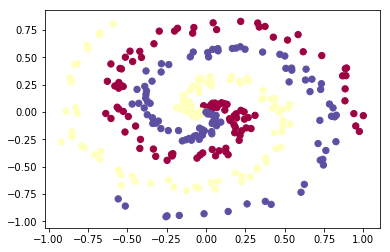

In [4]:
# generate random data in a spiral (from CS231n)
np.random.seed(123)
srcX = np.zeros((N,D)) # data matrix (each row = single example)
srcy = np.zeros(N, dtype='uint8') # class labels
for j in range(K):
  ix = range(n*j,n*(j+1))
  r = np.linspace(0.0,1,n) # radius
  t = np.linspace(j*4,(j+2)*4,n) + np.random.randn(n)*0.3 # theta
  srcX[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  srcy[ix] = j
# lets visualize the data:
plt.scatter(srcX[:, 0], srcX[:, 1], c=srcy, s=40, cmap=plt.cm.Spectral)
plt.show()

In [5]:
np.random.seed(123)

# initialize our model parameters
X = srcX.copy()
y = srcy.copy()

hidden = 100

reg_strength = 1.0e-4
learning_rate = 1.0e0
epochs = 10000

save_loss = np.zeros(epochs)
save_weight = np.zeros(epochs)
save_acc = np.zeros(epochs)

In [6]:
# initialize weights
W1 = 0.01 * np.random.randn(D,hidden)
b1 = np.zeros((1,hidden))

W2 = 0.01 * np.random.randn(hidden,K)
b2 = np.zeros((1,K))

In [7]:
for i in range(epochs):
    # predict class scores
    y1 = np.maximum(0, np.dot(X, W1) + b1)
    y_predict = np.dot(y1, W2) + b2

    # calculate softmax probabilities
    yexp = np.exp(y_predict - np.max(y_predict, axis=1, keepdims=True))
    p = yexp / np.sum(yexp, axis=1, keepdims=True)
    logp = - np.log(p[range(N),y])

    # compute softmax loss and regularization
    save_weight[i] = np.sum(W1*W1) + np.sum(W2*W2)
    save_loss[i] = np.sum(logp)/N + 0.5 * reg_strength * save_weight[i]
    save_acc[i] = np.mean(np.argmax(y_predict, axis=1) == y)

    # output layer gradients
    dy = p[:]
    dy[range(N),y] -= 1
    dy /= N
    
    dW2 = np.dot(y1.T, dy) + reg_strength*W2
    db2 = np.sum(dy, axis=0, keepdims=True)
    
    # hidden layer gradients
    dy1 = np.dot(dy, W2.T)
    dy1[y1 <= 0] = 0
    
    dW1 = np.dot(X.T, dy1) + reg_strength*W1
    db1 = np.sum(dy1, axis=0, keepdims=True)

    # learning step
    W1 -= learning_rate * dW1
    W2 -= learning_rate * dW2
    b1 -= learning_rate * db1
    b2 -= learning_rate * db2

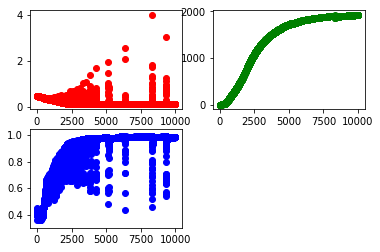

In [8]:
plt.subplot(221).scatter(range(epochs),save_loss, color='red')
plt.subplot(222).scatter(range(epochs),save_weight, color='green')
plt.subplot(223).scatter(range(epochs),save_acc, color='blue')

(-1.956783018181546, 1.8232169818184574)

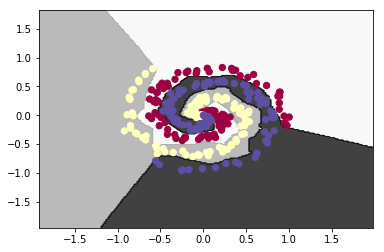

In [9]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.argmax(np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1) + b1), W2) + b2, axis=1).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Greys, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

ImportError: numpy.core.multiarray failed to import

ImportError: numpy.core.umath failed to import

ImportError: numpy.core.umath failed to import

In [340]:
y_hot = np_utils.to_categorical(y)

In [341]:
def baseline_model():
    model = Sequential()
    model.add(Dense(100, input_dim=D, activation='relu'))
#    model.add(Dense(10, activation='relu'))
#    model.add(Dense(10, activation='relu'))
    model.add(Dense(K, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [344]:
# model = baseline_model()
# model.fit(X, y_hot, epochs=1000, batch_size=N)
# y_predict = model.evaluate(X, y_hot)
# print("\n%s: %.2f%%" % (model.metrics_names[1], y_predict[1]*100))

np.random.seed(123)

model = KerasClassifier(baseline_model, epochs=10000, batch_size=N, verbose=0)

train, test = next(ShuffleSplit(test_size=.2, random_state=123).split(X))
train = range(N)
test = range(N)

model.fit(X[train], y_hot[train])

results = model.score(X[test], y_hot[test])

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 99.33% (0.00%)


(-1.956783018181546, 1.8232169818184574)

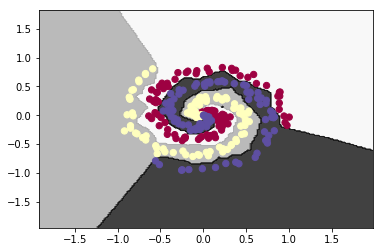

In [345]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Greys, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [347]:
150 / 60

2.5

In [24]:
str(list(range(10)))

'[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]'

In [2]:
params = {}
params['w1'] = 0

In [44]:
np.array(['blue','red','green','fart'])

array(['blue', 'red', 'green', 'fart'], 
      dtype='<U5')

In [58]:
num_layers = []
sum_layers = []
layers = []
i = 0
num_layers.append(np.random.randint(1,4)+1)
layers.append(np.sort([np.random.randint(32,128) for n in np.arange(1,num_layers[i])]))
layers[i] = layers[i][::-1]
sum_layers.append(np.sum(layers[i]))
print(layers)
print(num_layers)
print(sum_layers)

[array([38, 38])]
[3]
[76]


In [21]:
data = np.random.random((3,10))
N, D = data.shape
smean = np.sum(data, axis=0, keepdims=False) / N
svar = np.sum((data-smean)**2, axis=0, keepdims=False) / N
sdev = np.sqrt(svar)
print(data)
print(smean)
print(svar)
print(sdev)

[[ 0.77630014  0.20182844  0.09509839  0.99204476  0.40715611  0.26089531
   0.58282576  0.04138308  0.27029814  0.79049667]
 [ 0.36425748  0.29384933  0.9749607   0.3097581   0.00277798  0.05982654
   0.51821782  0.38837281  0.36293368  0.82502151]
 [ 0.95564657  0.32089289  0.75059859  0.0757977   0.15591371  0.99733743
   0.57336891  0.00854268  0.30754112  0.05926555]]
[ 0.69873473  0.27219022  0.60688589  0.45920019  0.18861594  0.43935309
  0.5581375   0.14609952  0.31359098  0.55826124]
[ 0.06129837  0.00259728  0.13935295  0.15108458  0.02778833  0.16241137
  0.0008117   0.02952792  0.00144852  0.12469701]
[ 0.24758508  0.05096354  0.37330008  0.388696    0.16669832  0.40300294
  0.02849027  0.1718369   0.03805948  0.35312464]


In [33]:
data = np.array([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
gamma = np.array([i+1 for i in range(data.shape[1])])


In [36]:
data + gamma

array([[ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20],
       [ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20],
       [ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20],
       [ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]])

In [12]:
np.log(10)

2.3025850929940459

In [11]:
tmp = np.array([10,2,3,4,5,6,7,8])


tmp[1:3]

array([2, 3])